In [ ]:
# Install necessary libraries
%pip install wandb
%pip install ultralytics
%pip install plotly
%pip install opencv-python
%pip install nbformat>=4.2.0
%pip install ipywidgets
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# To ensure packages are properly installed, we can run the following command
# This will restart the kernel after installation
from IPython.display import display, HTML
display(HTML("<script>Jupyter.notebook.kernel.restart()</script>"))

  Using cached ultralytics-8.3.143-py3-none-any.whl.metadata (37 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached scipy-1.15.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached torch-2.7.0-cp312-cp312-win_amd64.whl.metadata (29 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached idna-3.1

In [2]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp312-cp312-win_amd64.whl.metadata (29 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.0%2Bcu118-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
Using cached https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp312-cp312-win_amd64.whl (2908.4 MB)
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.5 MB ? eta -:--:--
   ----- ---------------------------------- 0.8/5.5 MB 2.2 MB/s eta 0:00:03
   ----------- ---------------------------- 1.6/5.5 MB 3.0 MB/s eta 0:00:02
   ----------------- ---------------------- 2.4/5.5 MB 3.4 MB/s eta 0:00:01
   ---------------------- ----------------- 3.1/5.5 MB 3.5 MB/s eta 0:00:01
   ------------------------------ --------- 4.2/5.5 MB 3.6 MB/s eta 0:00:01
   -

In [1]:
# Run this cell after kernel restart
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yaml
import torch

# Import OpenCV separately to verify it's installed correctly
import cv2
print(f"OpenCV version: {cv2.__version__}")

# Import the remaining dependencies
from ultralytics import YOLO


print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

OpenCV version: 4.11.0
PyTorch version: 2.7.0+cu118
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='c824158829d2d5a260437c86606438005ebb6565')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\zamza\_netrc
wandb: Currently logged in as: zamzam2960 (zamzam2960-robusta-studio) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:

# Paths to data directories
train_path = "./Train"
val_path = "./Val"

In [4]:
# Classes
classes = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

In [5]:
# Function to load images and labels
def load_data(data_path):
    images = []
    labels = []
    for class_label in classes:
        class_path = os.path.join(data_path, class_label, 'images')
        label_path = os.path.join(data_path, class_label, 'labels')
        for img_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_file = img_file.replace('.jpg', '.txt')
            label_file_path = os.path.join(label_path, label_file)
            if os.path.exists(label_file_path):
                with open(label_file_path, 'r') as file:
                    label_data = file.readline().strip().split()
                    if len(label_data) > 0:
                        images.append(img)
                        labels.append(label_data)
                    else:
                        print(f"Label file {label_file_path} is empty, skipping this image.")
            else:
                print(f"Label file {label_file_path} not found, skipping this image.")
    return images, labels

# Load training and validation data
train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)

Label file ./Val\Glioma\labels\gg (342).txt is empty, skipping this image.
Label file ./Val\No Tumor\labels\image(55).txt not found, skipping this image.
Label file ./Val\No Tumor\labels\image(61).txt not found, skipping this image.


In [6]:
# EDA - Visualize class distribution
train_counts = [len(os.listdir(os.path.join(train_path, cls, 'images'))) for cls in classes]
val_counts = [len(os.listdir(os.path.join(val_path, cls, 'images'))) for cls in classes]
eda_df = pd.DataFrame({'Class': classes, 'Train': train_counts, 'Validation': val_counts})

fig = go.Figure(data=[
    go.Bar(name='Train', x=eda_df['Class'], y=eda_df['Train']),
    go.Bar(name='Validation', x=eda_df['Class'], y=eda_df['Validation'])
])
fig.update_layout(barmode='group', title='Class Distribution in Training and Validation Sets')
fig.show()

In [7]:
# Image Preprocessing
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, (640, 640))
        processed_images.append(img_resized)
    return np.array(processed_images)

train_images = preprocess_images(train_images)
val_images = preprocess_images(val_images)

In [8]:
# Create YOLOv8 Dataset Configuration File
dataset_yaml = {
    'path': './',
    'train': 'Train',
    'val': 'Val',
    'names': classes
}

with open('./dataset.yaml', 'w') as file:
    yaml.dump(dataset_yaml, file)

In [9]:
# ---- optional: pin visible devices ----
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # only device 0 is visible

# ---- select device ----
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)             # => cuda:0

Using device: cuda:0


In [12]:
# ---- optional: pin visible devices ----
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # only device 0 is visible

# ---- select device ----
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)             # => cuda:0

# ---- load YOLO specifying the device up front ----
yolo_model = YOLO("yolov8s.pt")

# ---- train on that same device ----
try:
    train_results = yolo_model.train(
    data='./dataset.yaml',
    epochs=15,
    imgsz=640,
    batch=6,  # reduce to 6 if memory issues occur
    workers=6,
    device=device,
    half=True  # enables mixed precision training for speed boost
    )
except Exception as e:
    print(f"Error: {e}")

Using device: cuda:0
New https://pypi.org/project/ultralytics/8.3.153 available  Update with 'pip install -U ultralytics'
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train18, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

train: Scanning D:\pythonPojects\tumor\Train\Glioma\labels.cache... 4737 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4737/4737 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 32.617.1 MB/s, size: 26.3 KB)


val: Scanning D:\pythonPojects\tumor\Val\Glioma\labels.cache... 510 images, 3 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:00<?, ?it/s]


Plotting labels to runs\detect\train18\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000515625), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs\detect\train18
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.43G       1.09      1.797      1.279          3        640: 100%|██████████| 790/790 [02:12<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.89it/s]

                   all        512        554      0.816      0.679      0.749      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.94G      1.102      1.192      1.276          9        640: 100%|██████████| 790/790 [02:06<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.79it/s]

                   all        512        554      0.797      0.747      0.813      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.95G      1.065      1.063      1.245          5        640: 100%|██████████| 790/790 [02:06<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.67it/s]

                   all        512        554       0.77      0.772       0.84      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.95G      1.024     0.9598      1.228          2        640: 100%|██████████| 790/790 [02:04<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.58it/s]

                   all        512        554       0.86      0.828      0.896      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.98G     0.9979     0.8854      1.208         10        640: 100%|██████████| 790/790 [02:04<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.60it/s]

                   all        512        554      0.851      0.855      0.907      0.661


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      1.98G     0.9271     0.7601       1.18          3        640: 100%|██████████| 790/790 [02:04<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.10it/s]

                   all        512        554      0.892      0.838      0.915      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.98G     0.8948     0.6917      1.158          3        640: 100%|██████████| 790/790 [02:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.16it/s]

                   all        512        554      0.903      0.879       0.93      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      1.98G     0.8615     0.6494      1.134          3        640: 100%|██████████| 790/790 [02:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.02it/s]

                   all        512        554      0.891      0.883      0.942      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      2.02G     0.8373     0.5947      1.114          3        640: 100%|██████████| 790/790 [02:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.07it/s]

                   all        512        554      0.915      0.903      0.947      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      1.46G     0.8062     0.5611      1.097          3        640: 100%|██████████| 790/790 [02:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.94it/s]

                   all        512        554      0.938      0.895      0.949      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      1.96G     0.7846      0.523      1.075          4        640: 100%|██████████| 790/790 [02:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.30it/s]

                   all        512        554      0.948      0.887      0.951      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      1.99G     0.7599     0.4972      1.064          3        640: 100%|██████████| 790/790 [02:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.83it/s]

                   all        512        554      0.936      0.917      0.952       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      1.99G     0.7431     0.4578      1.056          3        640: 100%|██████████| 790/790 [02:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.18it/s]

                   all        512        554      0.921      0.934      0.956      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      1.99G     0.7199     0.4302      1.044          3        640: 100%|██████████| 790/790 [02:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.17it/s]

                   all        512        554      0.947      0.915      0.958      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      2.02G     0.6999     0.4107      1.029          3        640: 100%|██████████| 790/790 [02:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.15it/s]

                   all        512        554       0.93      0.933      0.959      0.785



15 epochs completed in 0.548 hours.
Optimizer stripped from runs\detect\train18\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train18\weights\best.pt, 22.5MB

Validating runs\detect\train18\weights\best.pt...
Ultralytics 8.3.143  Python-3.12.10 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.97it/s]


                   all        512        554       0.93      0.933       0.96      0.786
                Glioma        135        153      0.893      0.872      0.926      0.738
            Meningioma        140        142      0.979      0.995      0.992       0.84
              No Tumor         98         98      0.979      0.972      0.985      0.834
             Pituitary        154        161      0.867      0.893      0.934      0.732
Speed: 0.3ms preprocess, 6.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train18


In [13]:
# Save the YOLOv8 model
yolo_model.save('./yolov8_model_30epoch.pt')


0: 640x640 1 Glioma, 73.3ms
Speed: 11.6ms preprocess, 73.3ms inference, 9.6ms postprocess per image at shape (1, 3, 640, 640)


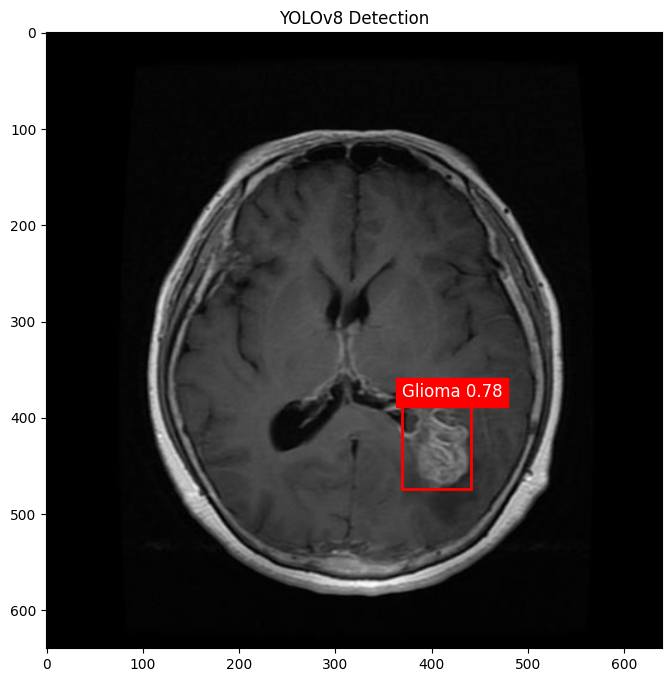


0: 640x640 4 Gliomas, 67.1ms
Speed: 7.4ms preprocess, 67.1ms inference, 10.9ms postprocess per image at shape (1, 3, 640, 640)


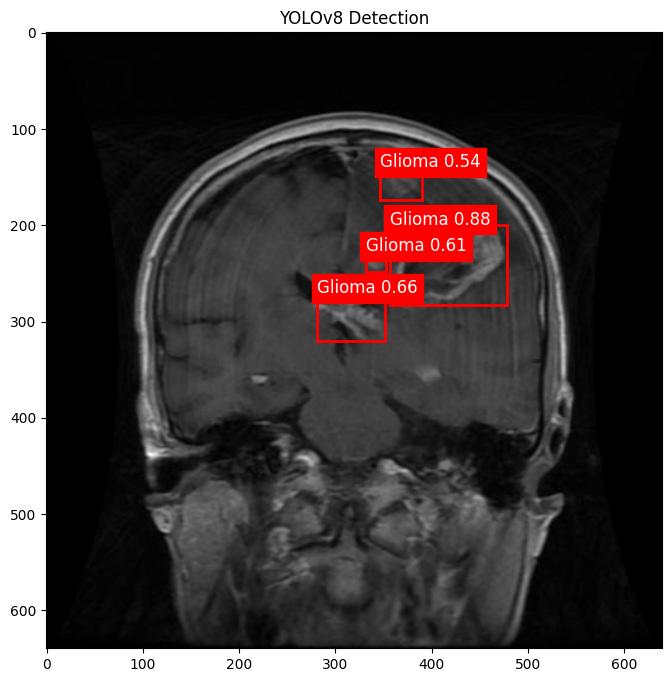


0: 640x640 4 Gliomas, 66.2ms
Speed: 7.6ms preprocess, 66.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


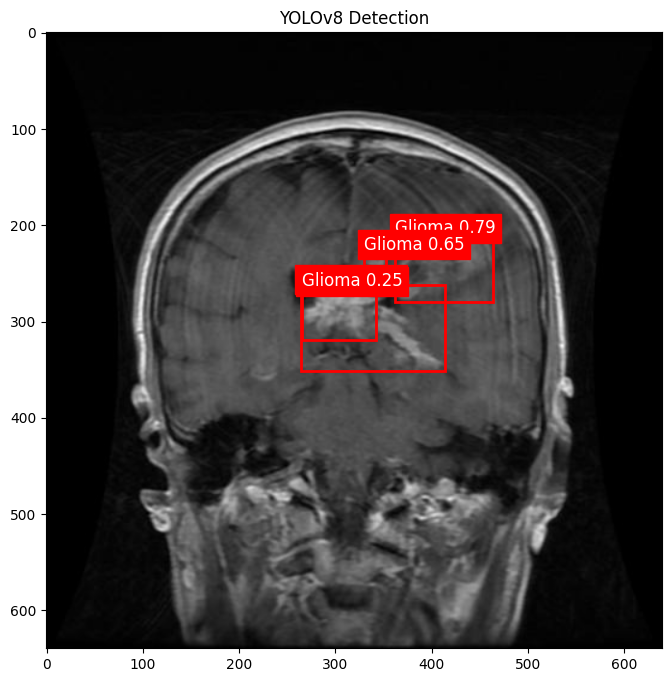


0: 640x640 2 Gliomas, 66.3ms
Speed: 9.1ms preprocess, 66.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


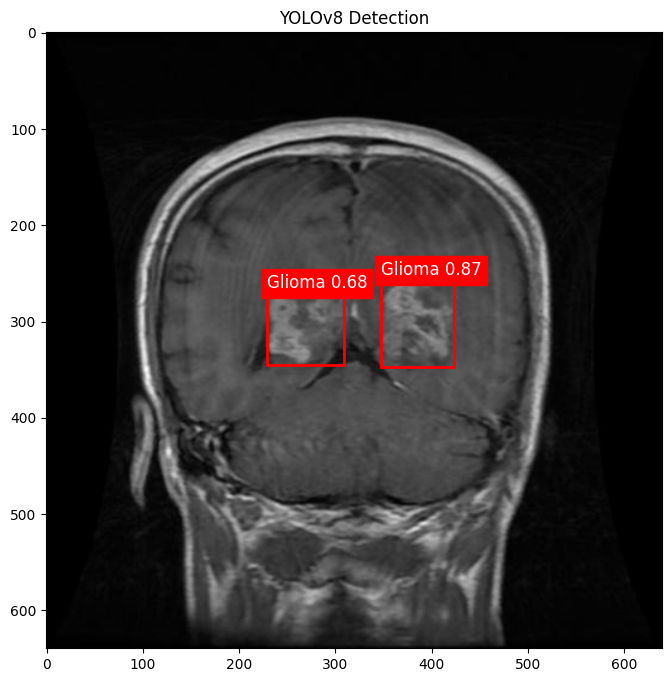


0: 640x640 6 Gliomas, 66.3ms
Speed: 7.7ms preprocess, 66.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


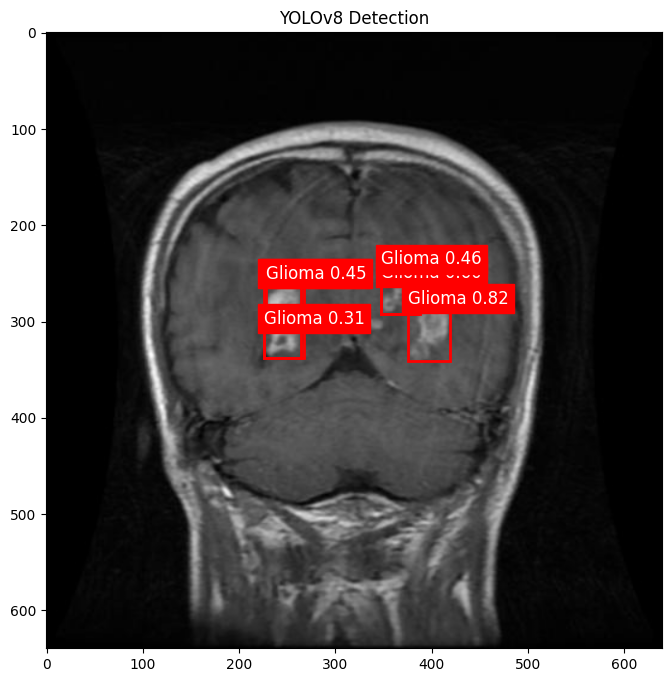


0: 640x640 1 Glioma, 1 Pituitary, 66.4ms
Speed: 8.5ms preprocess, 66.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


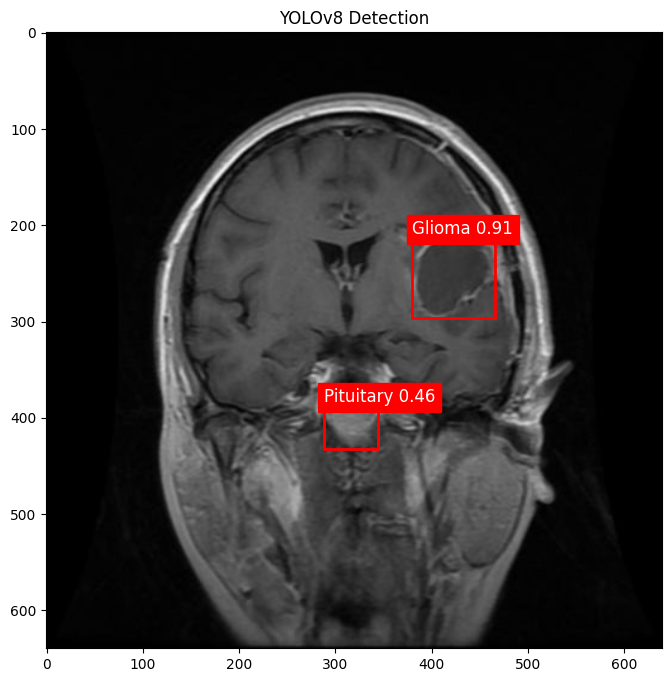


0: 640x640 1 Glioma, 66.2ms
Speed: 7.0ms preprocess, 66.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


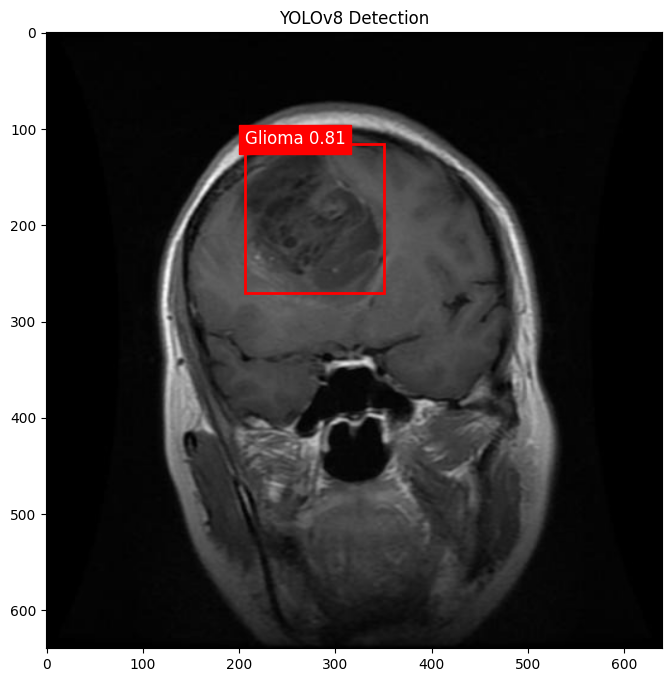


0: 640x640 1 Glioma, 66.2ms
Speed: 6.8ms preprocess, 66.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


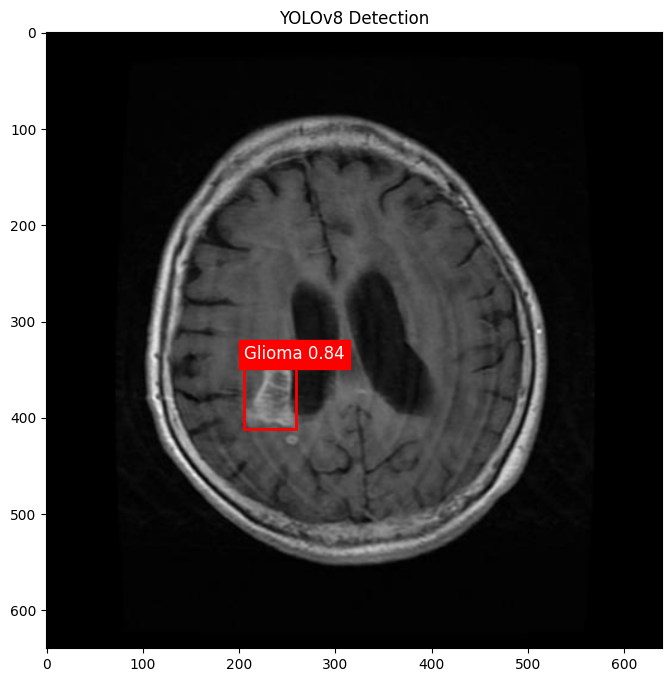


0: 640x640 1 Glioma, 66.5ms
Speed: 5.7ms preprocess, 66.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


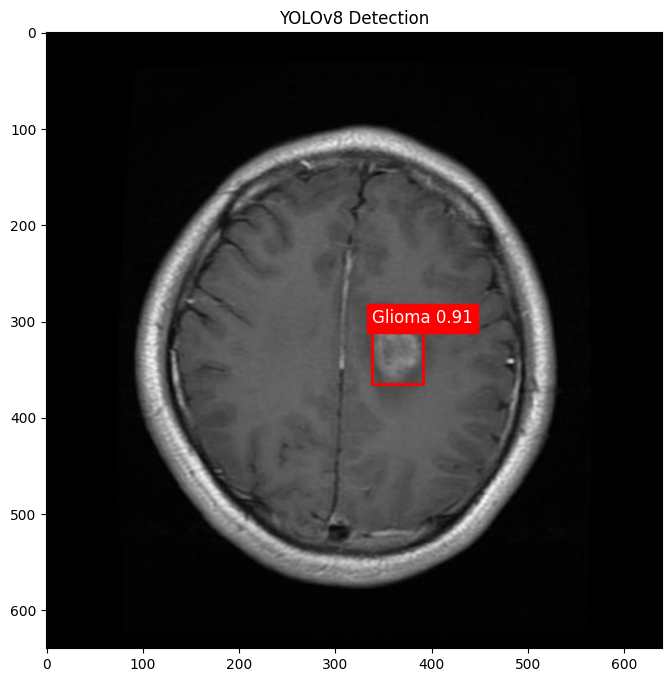


0: 640x640 1 Glioma, 68.4ms
Speed: 8.2ms preprocess, 68.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


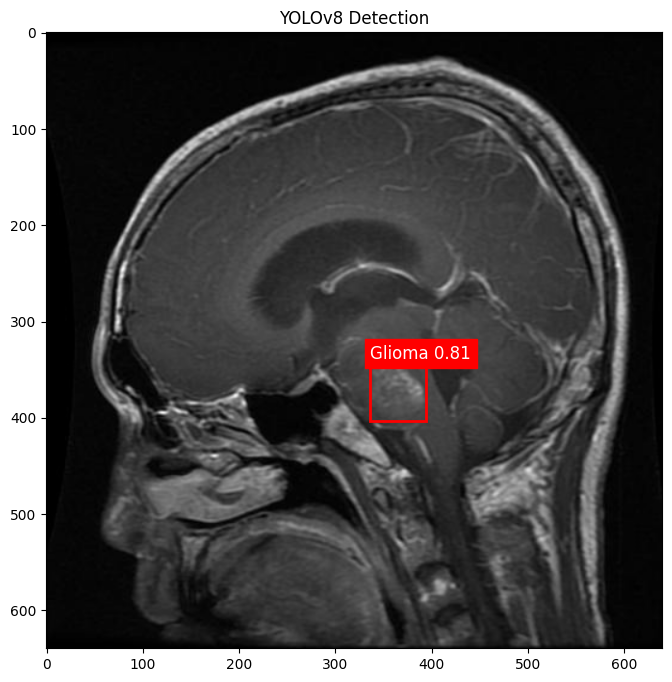

In [14]:
%matplotlib inline
# Function to display detection results with highlighted parts
def display_samples(images, yolo_model):
    for i in range(10):
        img = images[i]
        result = yolo_model.predict(img)[0]  # Assuming batch size of 1, take the first result

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        ax = plt.gca()

        for detection in result.boxes:
            x1, y1, x2, y2 = detection.xyxy[0].cpu().numpy()
            conf = detection.conf[0].cpu().numpy()
            cls = detection.cls[0].cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f"{classes[int(cls)]} {conf:.2f}", color='white', fontsize=12, backgroundcolor='red')
        
        plt.title(f'YOLOv8 Detection')
        plt.show()

display_samples(val_images, yolo_model)

In [ ]:
yolo_model = YOLO('./yolov8_model_30epoch.pt')

# Evaluate the model on the validation dataset
val_results = yolo_model.val(data='./dataset.yaml', imgsz=640, batch=8, device=device)

# Print the evaluation metrics using the correct attributes
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")
print(f"mAP50: {val_results.box.map50:.4f}")
print(f"mAP50-95: {val_results.box.map:.4f}")

Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 37.118.1 MB/s, size: 30.0 KB)


val: Scanning D:\pythonPojects\tumor\Val\Glioma\labels.cache... 510 images, 3 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:00<?, ?it/s]


In [19]:
# I want the f1 score from the validation results
f1_score = 2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr)
print(f"F1 Score: {f1_score:.4f}")

F1 Score: 0.9397


In [ ]:
confusion = results.confusion_matrix
class_names = model.names

# Define thresholds to evaluate
thresholds = np.linspace(0.05, 0.95, 19)

# Store average precision and recall at each threshold
precision_list = []
recall_list = []
f1_list = []

# Loop over thresholds
for conf_thres in thresholds:
    stats = model.val(conf=conf_thres, verbose=False)
    
    # Average precision & recall across all classes
    precision = np.mean(stats.metrics.precision_per_class)
    recall = np.mean(stats.metrics.recall_per_class)
    
    precision_list.append(precision)
    recall_list.append(recall)
    
    # F1 score calculation
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    f1_list.append(f1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label="Precision", marker='o', color='blue')
plt.plot(thresholds, recall_list, label="Recall", marker='s', color='orange')
plt.plot(thresholds, f1_list, label="F1 Score", marker='^', color='green')
plt.axvline(x=0.5, color='gray', linestyle='--', label="Selected Threshold (0.5)")

plt.title("Confidence Threshold Analysis on Validation Set")
plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

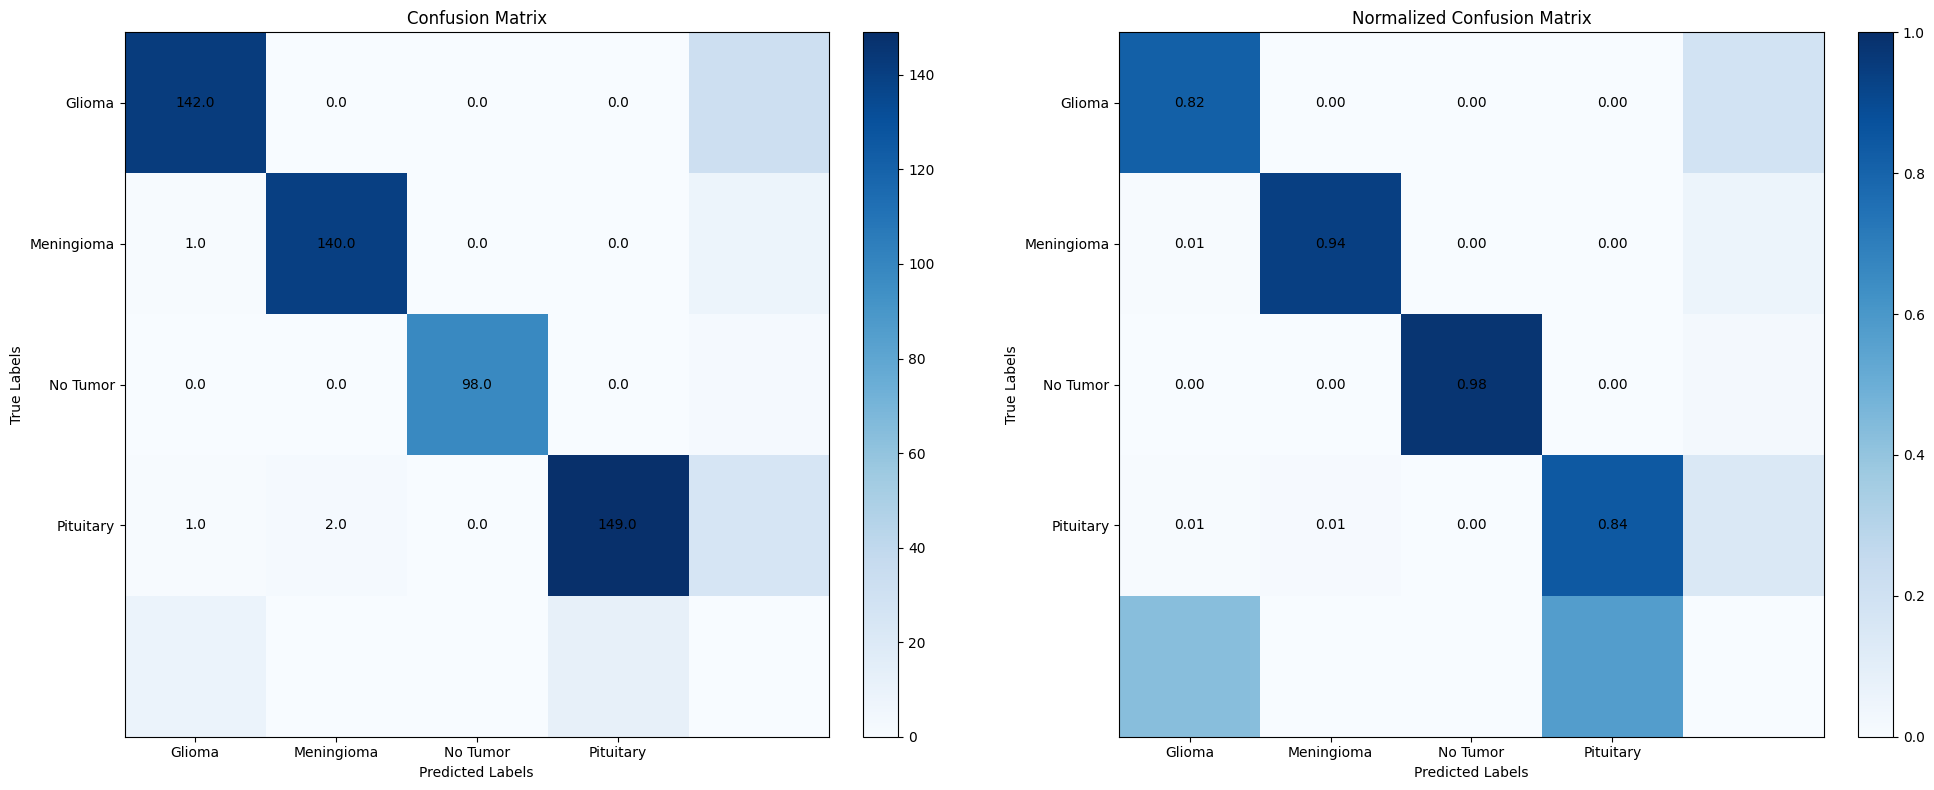

In [16]:
# Visualize the Confusion Matrix
def plot_confusion_matrix(val_results):
    # Handle different types of confusion matrix data
    try:
        # If it's a PyTorch tensor, convert to numpy
        if hasattr(val_results.confusion_matrix.matrix, 'cpu'):
            conf_matrix = val_results.confusion_matrix.matrix.cpu().numpy()
        else:
            # If it's already a numpy array
            conf_matrix = val_results.confusion_matrix.matrix
    except AttributeError:
        # If confusion_matrix is already a numpy array
        conf_matrix = val_results.confusion_matrix
    
    classes_idx = range(len(classes))
    
    # Create a normalized confusion matrix (handling division by zero)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    row_sums = np.where(row_sums == 0, 1, row_sums)  # Replace zeros with ones to avoid division by zero
    conf_matrix_norm = conf_matrix / row_sums
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot raw confusion matrix
    im1 = ax1.imshow(conf_matrix, cmap='Blues')
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Labels')
    ax1.set_ylabel('True Labels')
    ax1.set_xticks(classes_idx)
    ax1.set_yticks(classes_idx)
    ax1.set_xticklabels(classes)
    ax1.set_yticklabels(classes)
    
    # Add text annotations to raw matrix
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax1.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center')
    
    # Plot normalized confusion matrix
    im2 = ax2.imshow(conf_matrix_norm, cmap='Blues', vmin=0, vmax=1)
    ax2.set_title('Normalized Confusion Matrix')
    ax2.set_xlabel('Predicted Labels')
    ax2.set_ylabel('True Labels')
    ax2.set_xticks(classes_idx)
    ax2.set_yticks(classes_idx)
    ax2.set_xticklabels(classes)
    ax2.set_yticklabels(classes)
    
    # Add text annotations to normalized matrix
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax2.text(j, i, f'{conf_matrix_norm[i, j]:.2f}', ha='center', va='center')
    
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix from validation results
plot_confusion_matrix(val_results)

In [17]:
# Plot Precision-Recall Curves for each class
def plot_pr_curves(val_results):
    # Extract PR curve data from validation results
    pr_data = val_results.pr_curve
    
    # Create a figure for plotting PR curves
    plt.figure(figsize=(10, 8))
    
    # Plot PR curve for each class
    for i, cls_name in enumerate(classes):
        if i < len(pr_data):
            precision = pr_data[i][:, 0]
            recall = pr_data[i][:, 1]
            plt.plot(recall, precision, lw=2, label=f'{cls_name} (AP: {val_results.box.ap[i]:.4f})')
    
    # Add grid, labels, and legend
    plt.grid(True)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves by Class')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='best')
    plt.show()

# Plot the PR curves
plot_pr_curves(val_results)

AttributeError: 'DetMetrics' object has no attribute 'pr_curve'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class.
        names (dict): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
    

In [18]:
# Visualize Per-Class Performance Metrics
def plot_class_metrics(val_results):
    # Extract per-class metrics
    class_metrics = {
        'Precision': val_results.box.pc,  # Precision per class
        'Recall': val_results.box.rc,    # Recall per class
        'AP50': val_results.box.ap50,    # AP50 per class
        'AP': val_results.box.ap        # AP (mAP@0.5:0.95) per class
    }
    
    # Create a DataFrame for easier plotting
    metrics_df = pd.DataFrame()
    for metric_name, metric_values in class_metrics.items():
        for i, cls_name in enumerate(classes):
            if i < len(metric_values):
                metrics_df = pd.concat([metrics_df, pd.DataFrame({
                    'Class': cls_name,
                    'Metric': metric_name,
                    'Value': metric_values[i]
                }, index=[0])], ignore_index=True)
    
    # Create a grouped bar chart
    plt.figure(figsize=(12, 8))
    
    # Plot using seaborn if available, otherwise use plain matplotlib
    try:
        import seaborn as sns
        sns.set_style("whitegrid")
        sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df)
    except ImportError:
        # Grouped bar chart with matplotlib
        metrics = list(class_metrics.keys())
        x = np.arange(len(classes))  
        width = 0.2  # width of the bars
        
        for i, metric in enumerate(metrics):
            offset = width * (i - len(metrics)/2 + 0.5)
            values = [class_metrics[metric][j] if j < len(class_metrics[metric]) else 0 
                      for j in range(len(classes))]
            plt.bar(x + offset, values, width, label=metric)
        
        plt.xticks(x, classes)
    
    plt.title('Performance Metrics by Class')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.ylim([0, 1.05])
    plt.legend(title='Metric', loc='lower right')
    plt.tight_layout()
    plt.show()

# Plot the per-class metrics
plot_class_metrics(val_results)

AttributeError: 'Metric' object has no attribute 'pc'. See valid attributes below.

    Class for computing evaluation metrics for Ultralytics YOLO models.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    


0: 640x640 2 Meningiomas, 47.1ms
Speed: 5.6ms preprocess, 47.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results for ./test/image.webp: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1.], device='cuda:0')
conf: tensor([0.7260, 0.6302], device='cuda:0')
data: tensor([[148.8454, 300.8158, 245.3765, 404.9203,   0.7260,   1.0000],
        [379.2673, 390.9511, 436.2421, 529.1490,   0.6302,   1.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (650, 650)
shape: torch.Size([2, 6])
xywh: tensor([[197.1110, 352.8680,  96.5311, 104.1044],
        [407.7547, 460.0500,  56.9748, 138.1979]], device='cuda:0')
xywhn: tensor([[0.3032, 0.5429, 0.1485, 0.1602],
        [0.6273, 0.7078, 0.0877, 0.2126]], device='cuda:0')
xyxy: tensor([[148.8454, 300.8158, 245.3765, 404.9203],
        [379.2673, 390.9511, 436.2421, 529.1490]], device='cuda:0')
xyxyn: tensor([[0.2290, 0.4628, 0.3775, 0.6230],
        [0.5835, 0.6015, 0.6711, 0.8141]], device

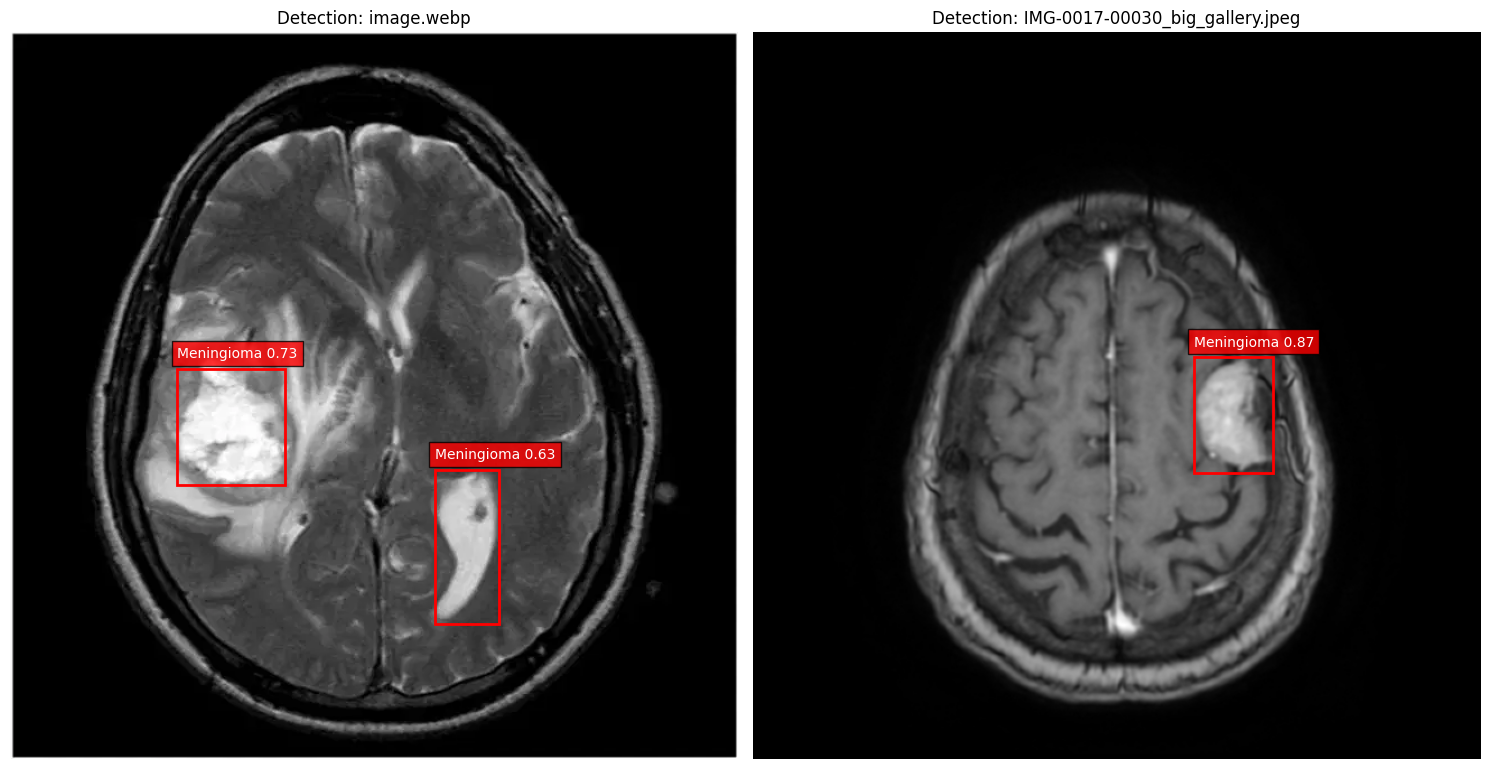

In [28]:
# Test the model on new images
def test_on_custom_images(model, image_paths):
    plt.figure(figsize=(15, 15))
    rows = int(np.ceil(len(image_paths) / 2))
    
    for i, img_path in enumerate(image_paths):
        # Load and process the image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not load image: {img_path}")
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Run inference
        results = model.predict(img, conf=0.25)[0]
        print(f"Results for {img_path}: {results.boxes}")
        # Create subplot
        plt.subplot(rows, 2, i+1)
        
        # Display the image
        plt.imshow(img)
        
        # Draw bounding boxes and labels
        for detection in results.boxes:
            x1, y1, x2, y2 = detection.xyxy[0].cpu().numpy()
            conf = detection.conf[0].cpu().numpy()
            cls = int(detection.cls[0].cpu().numpy())
            
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1, 
                linewidth=2, edgecolor='r', facecolor='none'
            )
            plt.gca().add_patch(rect)
            plt.text(
                x1, y1-10, 
                f"{classes[cls]} {conf:.2f}", 
                color='white', fontsize=10, 
                bbox=dict(facecolor='red', alpha=0.8)
            )
        
        plt.title(f"Detection: {os.path.basename(img_path)}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test the model on sample validation images
# You can replace this with paths to your own custom test images
sample_images = [
    './test/image.webp',
    './test/IMG-0017-00030_big_gallery.jpeg',
]
# for class_label in classes:
#     img_dir = os.path.join(val_path, class_label, 'images')
#     image_files = os.listdir(img_dir)
#     if image_files:
#         # Add one sample image from each class
#         sample_images.append(os.path.join(img_dir, image_files[0]))

# Load the model from ./yolov8_model.pt
yolo_model = YOLO('./yolov8_model.pt')
# If we have sample images, test the model
if sample_images:
    test_on_custom_images(yolo_model, sample_images)
else:
    print("No sample images found in the validation directories.")

In [12]:
# Generate a comprehensive evaluation report
def generate_evaluation_report(val_results):
    # Create a summary dataframe
    summary_data = {
        'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision', 'Recall'],
        'Value': [
            val_results.box.map50,
            val_results.box.map,
            val_results.box.mp,
            val_results.box.mr
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    
    # Per-class metrics
    class_data = []
    for i, cls in enumerate(classes):
        if i < len(val_results.box.ap):
            class_data.append({
                'Class': cls,
                'AP@0.5': val_results.box.ap50[i],
                'AP@0.5:0.95': val_results.box.ap[i],
                'Precision': val_results.box.pc[i],
                'Recall': val_results.box.rc[i]
            })
    class_df = pd.DataFrame(class_data)
    
    # Display the evaluation report
    print("\n==================== MODEL EVALUATION REPORT ====================")
    print("\nOVERALL METRICS:")
    print(summary_df.to_string(index=False))
    
    print("\nPER-CLASS METRICS:")
    print(class_df.to_string(index=False))
    
    print("\nINFERENCE SPEED:")
    print(f"Inference time per image: {val_results.speed['inference']:.2f} ms")
    print(f"Preprocessing time: {val_results.speed['preprocess']:.2f} ms")
    print(f"Postprocessing time: {val_results.speed['postprocess']:.2f} ms")
    print(f"Total time per image: {sum(val_results.speed.values()):.2f} ms")
    
    print("\n==================================================================")

# Generate the evaluation report
generate_evaluation_report(val_results)

NameError: name 'val_results' is not defined

Visualizing results from: ./runs/detect/train13


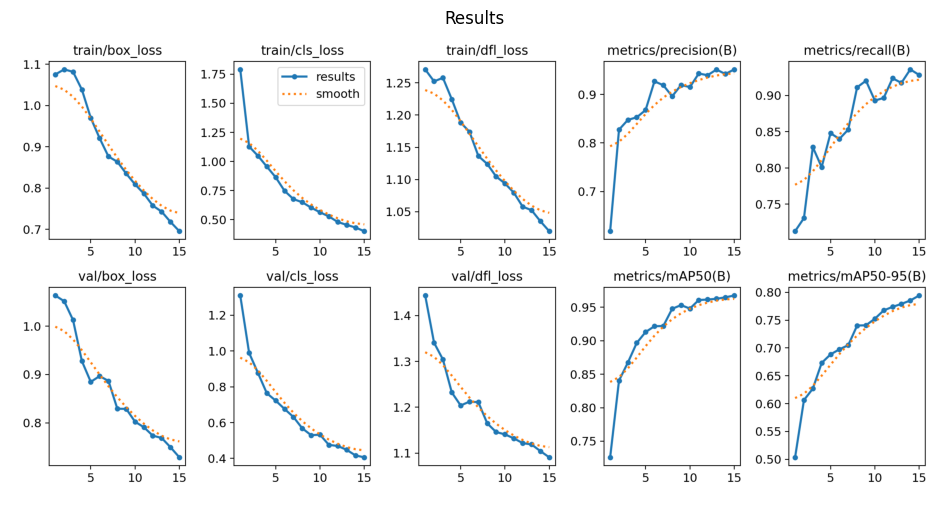

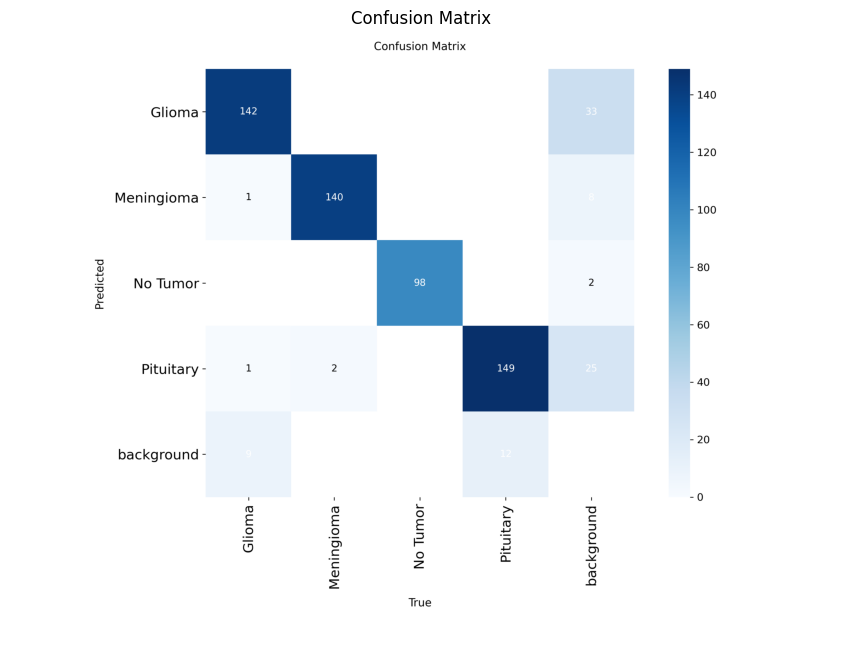

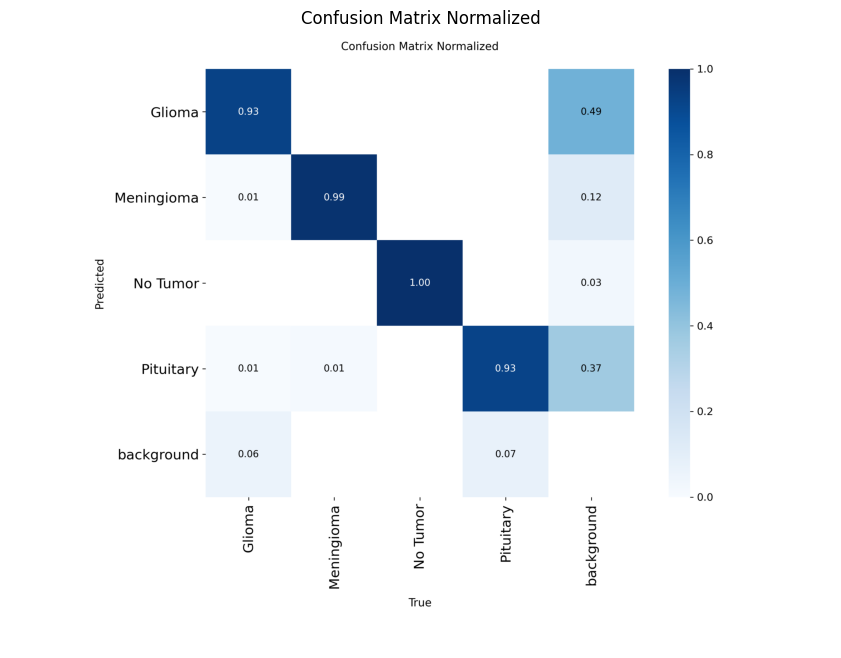

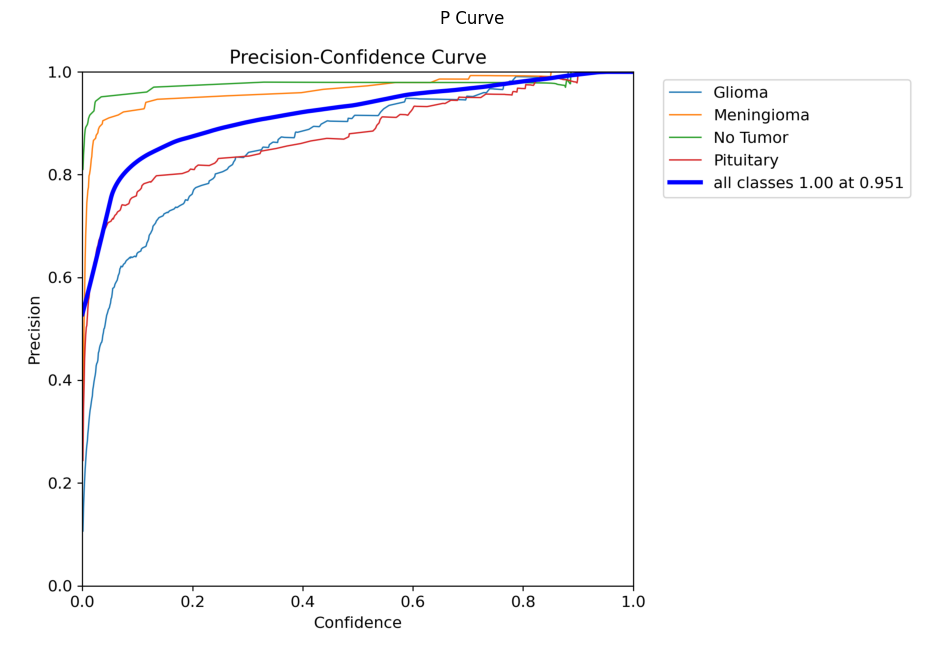

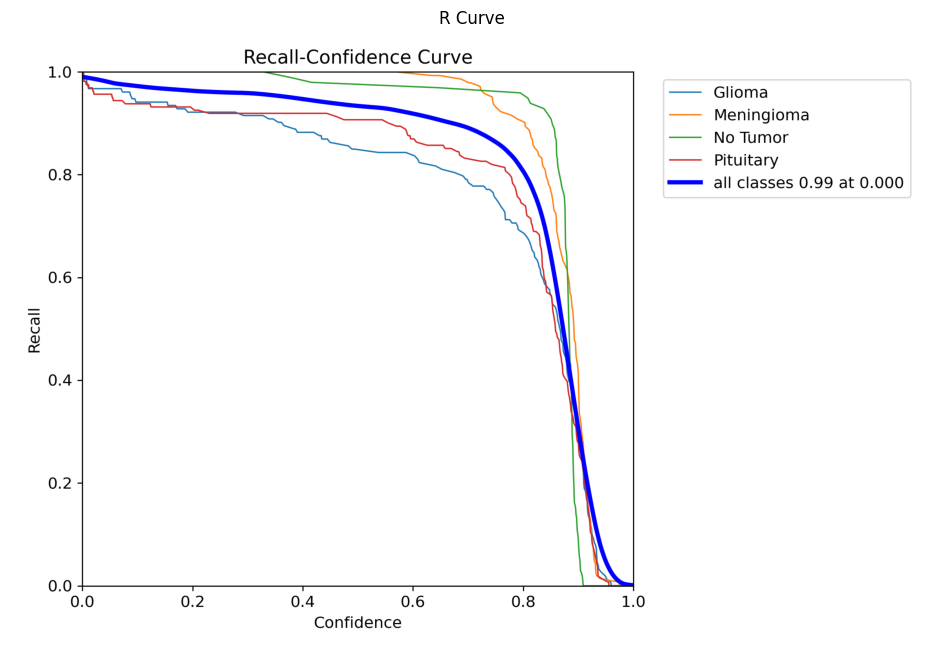

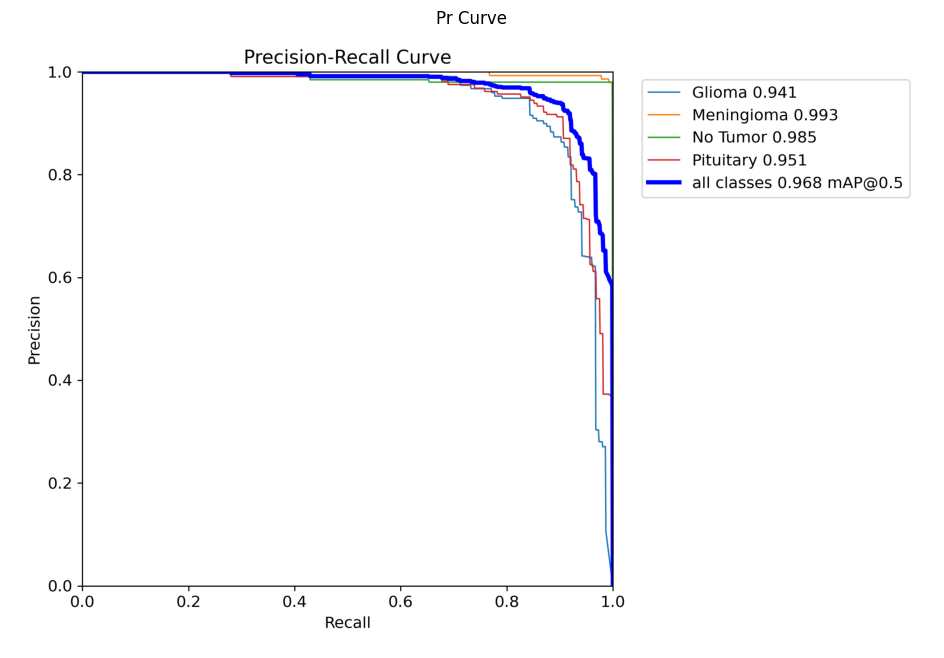

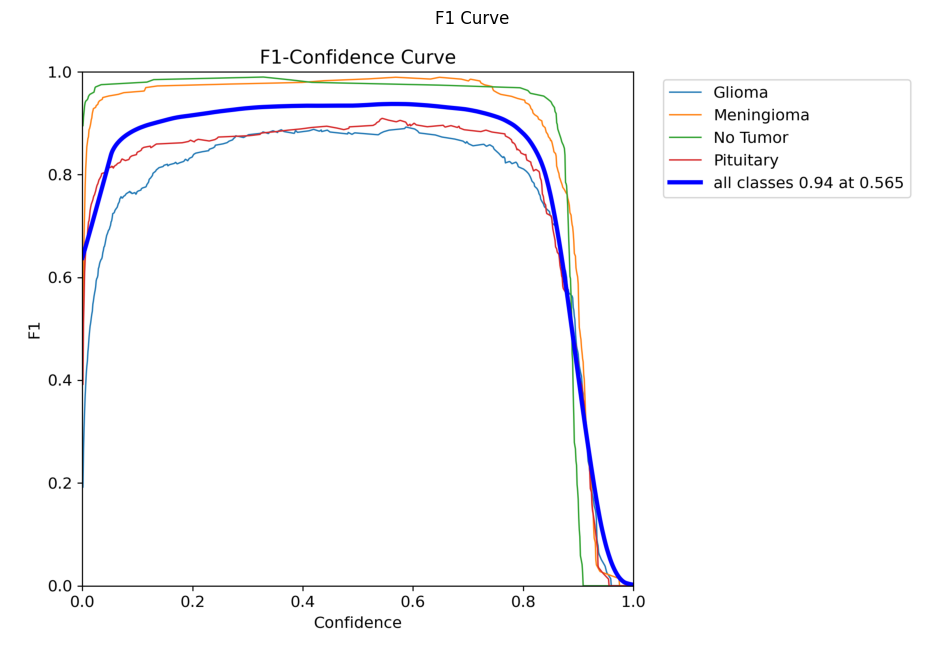

In [23]:
# Visualize Training Results from the runs directory
%matplotlib inline
import glob
from PIL import Image

# Find the latest training run
run_dirs = sorted(glob.glob('./runs/detect/train13'))

if run_dirs:
    latest_run = run_dirs[-1]
    print(f"Visualizing results from: {latest_run}")
    
    # Create a list of result plots to display
    result_plots = [
        'results.png',
        'confusion_matrix.png', 
        'confusion_matrix_normalized.png',
        'P_curve.png',
        'R_curve.png',
        'PR_curve.png',
        'F1_curve.png'
    ]
    
    # Display each plot if it exists
    for plot_name in result_plots:
        plot_path = f"{latest_run}/{plot_name}"
        if os.path.exists(plot_path):
            img = Image.open(plot_path)
            plt.figure(figsize=(12, 8))
            plt.imshow(np.array(img))
            plt.axis('off')
            plt.title(f"{plot_name.replace('.png', '').replace('_', ' ').title()}")
            plt.show()
        else:
            print(f"Plot not found: {plot_path}")
else:
    print("No training runs found in ./runs/detect/")



0: 640x640 5 Gliomas, 135.4ms
Speed: 6.3ms preprocess, 135.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Gliomas, 41.3ms
Speed: 5.4ms preprocess, 41.3ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Gliomas, 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Gliomas, 13.9ms
Speed: 2.8ms preprocess, 13.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Gliomas, 13.1ms
Speed: 2.5ms preprocess, 13.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 16.6ms
Speed: 3.1ms preprocess, 16.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 12.6ms
Speed: 1.5ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 12.1ms
Speed: 2.4ms preprocess, 12.1ms inference, 2.4ms postprocess per image at shape (1

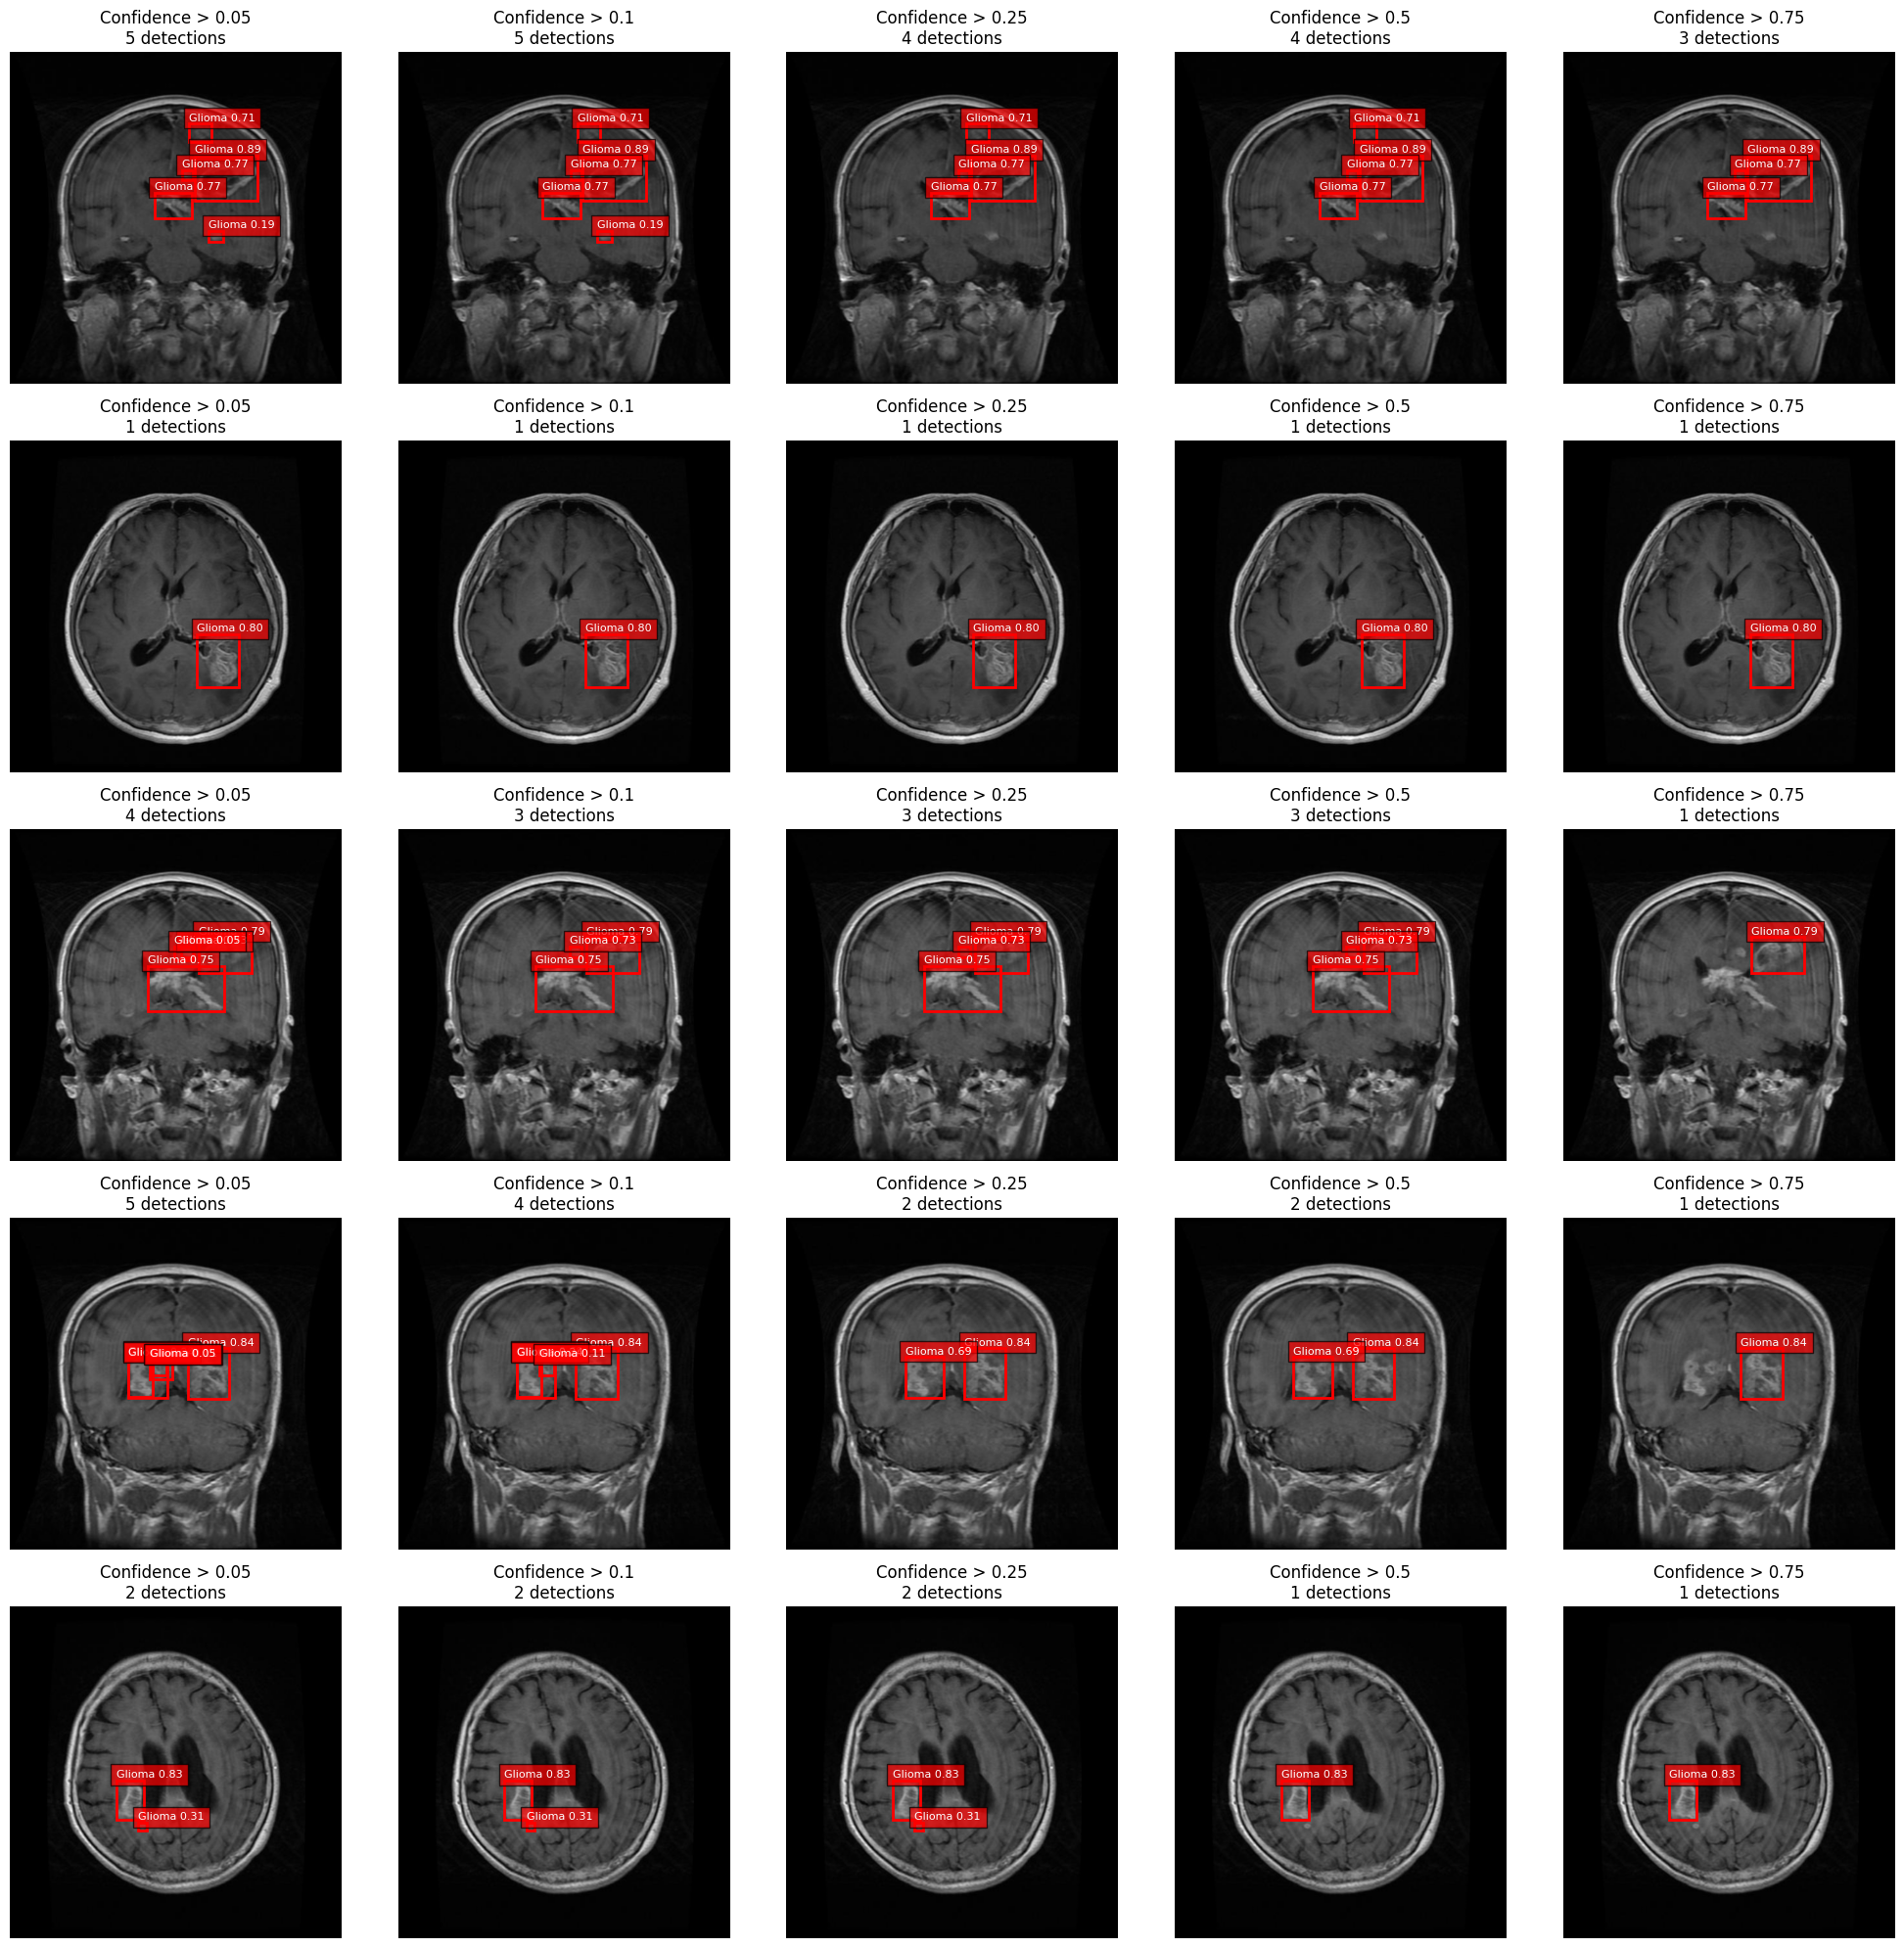

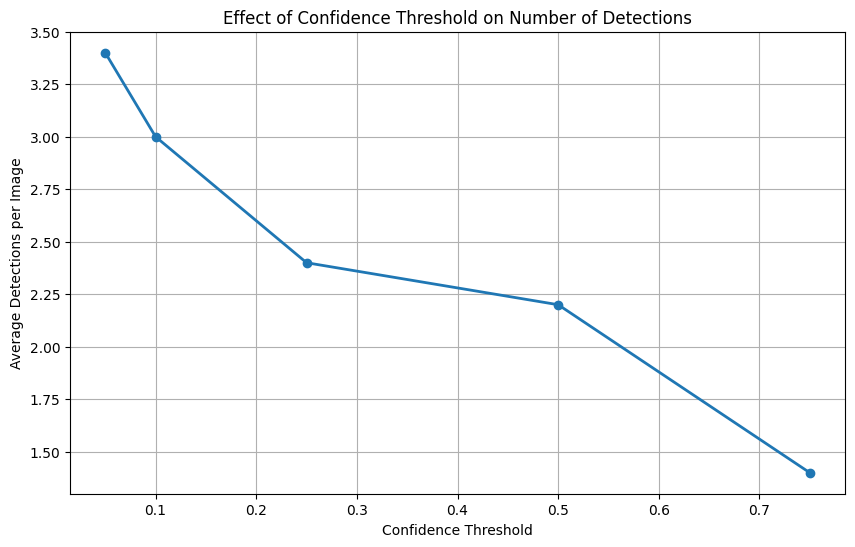

In [24]:
# Analyze the effect of confidence threshold on detection performance
def analyze_confidence_thresholds(model, images, true_labels=None, thresholds=None):
    if thresholds is None:
        thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]
    
    results = {}
    
    # Take 5 random sample images
    if len(images) > 5:
        import random
        sample_indices = random.sample(range(len(images)), 5)
        sample_images = [images[i] for i in sample_indices]
    else:
        sample_images = images
    
    # Create a figure to display results
    fig, axes = plt.subplots(len(sample_images), len(thresholds), figsize=(20, 4*len(sample_images)))
    
    # Ensure axes is 2D even if there's only one image
    if len(sample_images) == 1:
        axes = np.array([axes])
    
    # For each sample image
    for i, img in enumerate(sample_images):
        # For each confidence threshold
        for j, conf in enumerate(thresholds):
            # Run prediction with this confidence threshold
            result = model.predict(img, conf=conf)[0]
            
            # Record the number of detections
            if i == 0:
                results[conf] = len(result.boxes)
            else:
                results[conf] += len(result.boxes)
            
            # Display the image with detections
            ax = axes[i, j]
            ax.imshow(img)
            ax.set_title(f"Confidence > {conf}\n{len(result.boxes)} detections")
            ax.axis('off')
            
            # Draw bounding boxes
            for detection in result.boxes:
                x1, y1, x2, y2 = detection.xyxy[0].cpu().numpy()
                conf_score = detection.conf[0].cpu().numpy()
                cls = int(detection.cls[0].cpu().numpy())
                
                rect = patches.Rectangle(
                    (x1, y1), x2-x1, y2-y1, 
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(x1, y1-5, f"{classes[cls]} {conf_score:.2f}", 
                       color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Plot the average number of detections vs threshold
    avg_detections = {k: v/len(sample_images) for k, v in results.items()}
    plt.figure(figsize=(10, 6))
    plt.plot(list(avg_detections.keys()), list(avg_detections.values()), 'o-', linewidth=2)
    plt.grid(True)
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Average Detections per Image')
    plt.title('Effect of Confidence Threshold on Number of Detections')
    plt.show()
    
    return results

# Run the confidence threshold analysis
thresholds = [0.05, 0.1, 0.25, 0.5, 0.75]
confidence_results = analyze_confidence_thresholds(yolo_model, val_images[:10], thresholds=thresholds)


Validation Batch Images - Predictions vs Ground Truth:


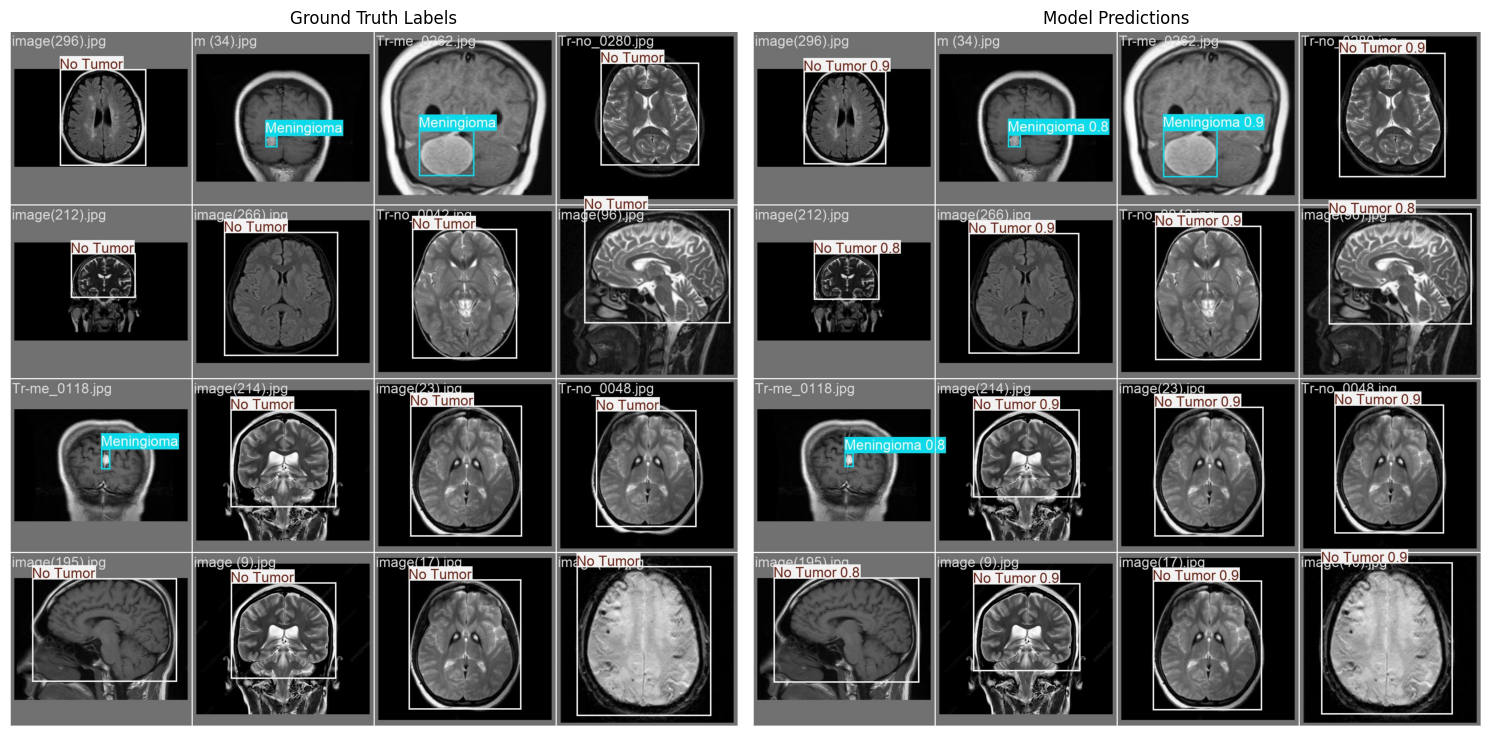

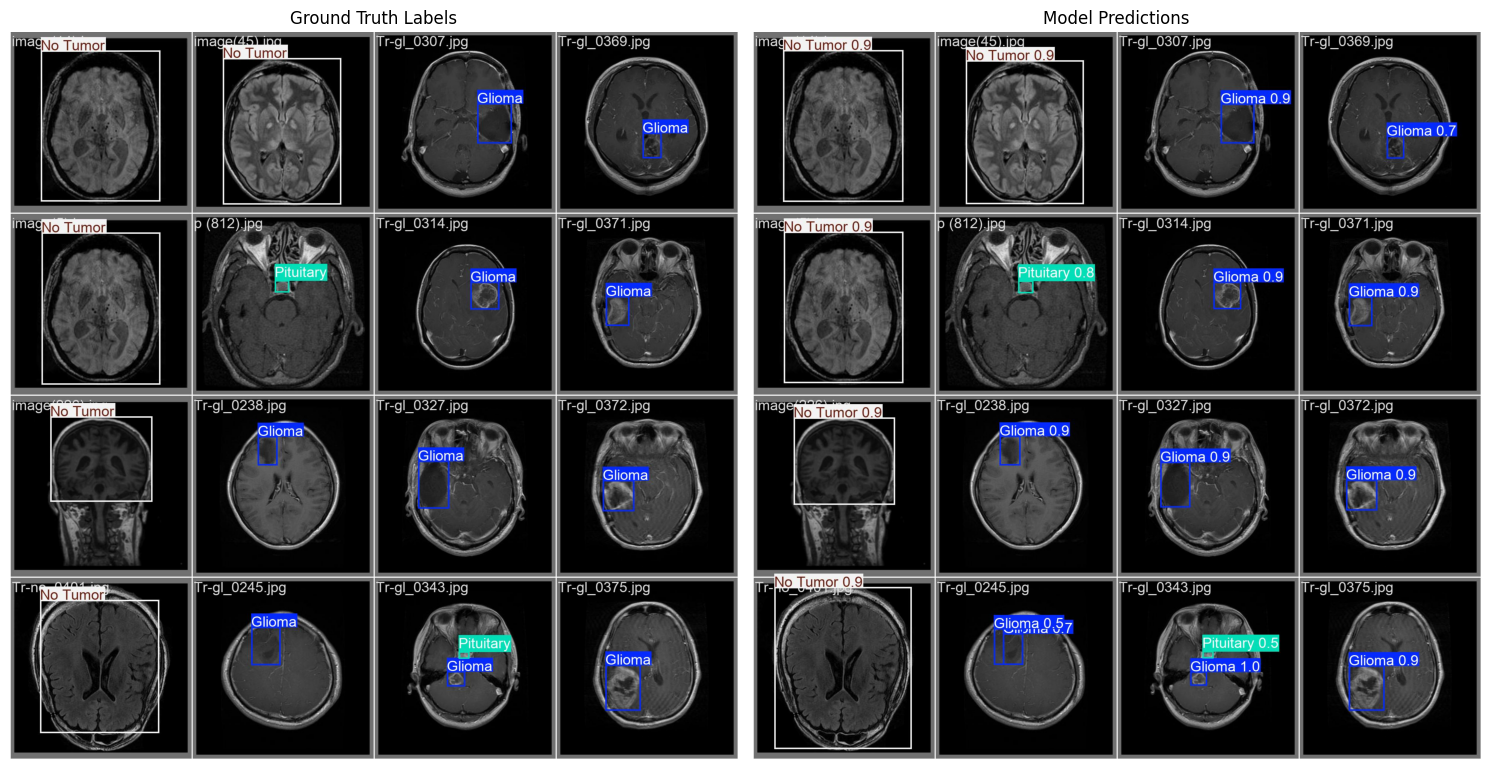

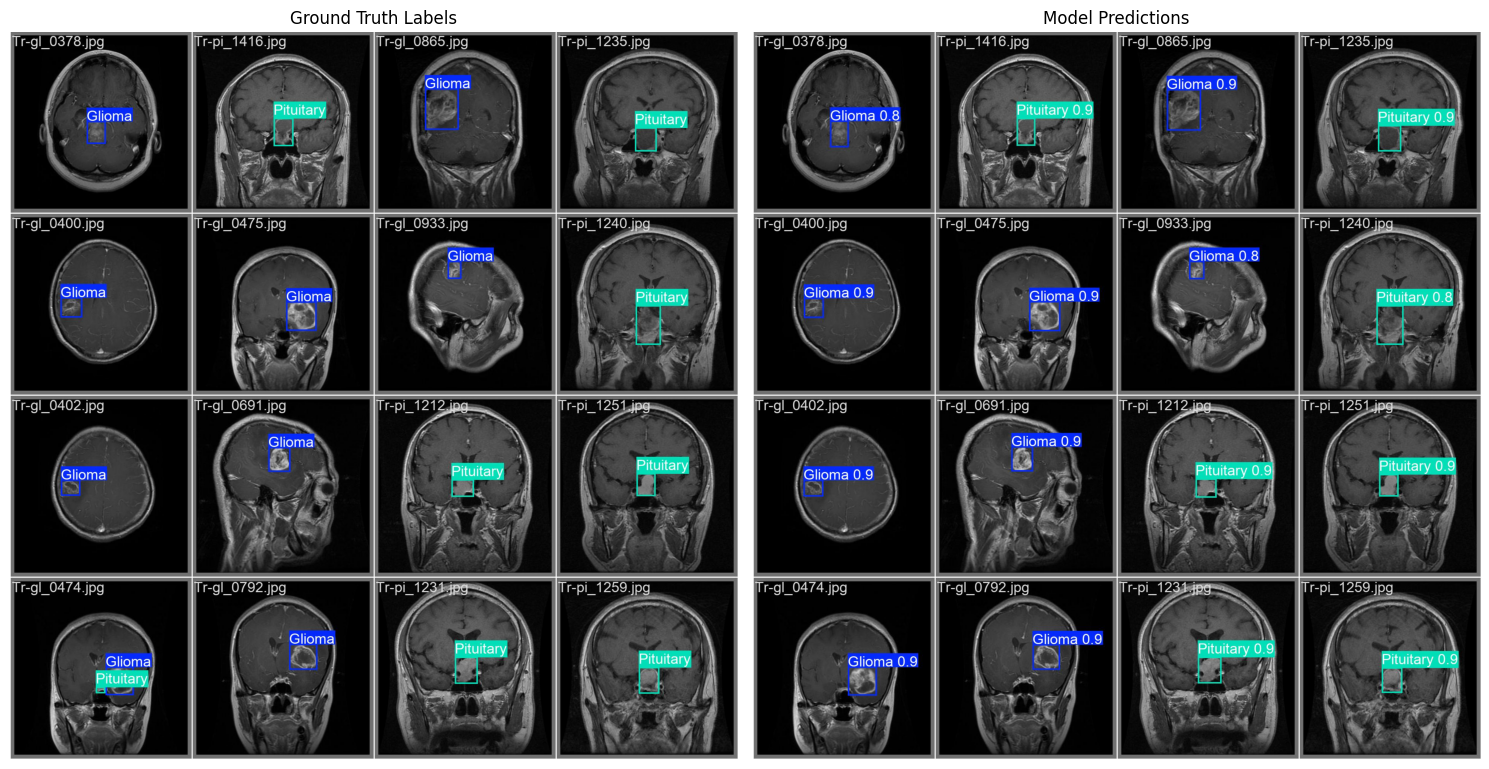


Training Progress - Sample Batches:


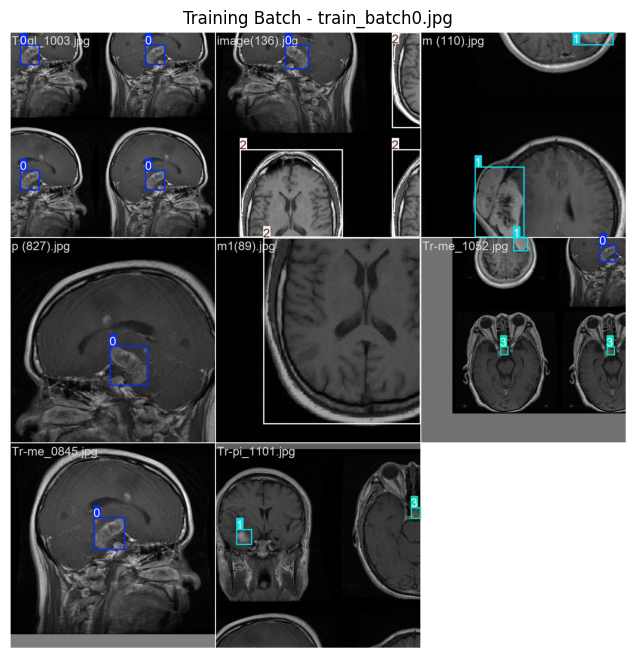

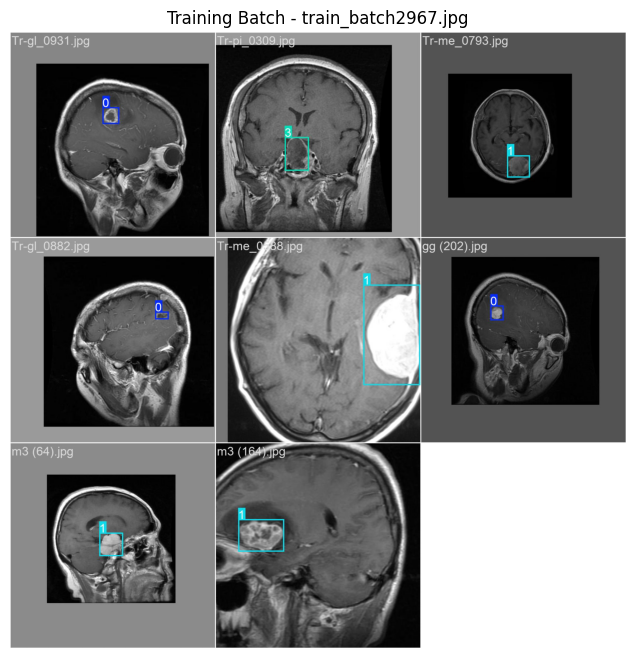

In [26]:
# Visualize a sample of test batch images from the training runs
def display_training_samples():
    # Find all training batch images from the latest run
    run_dirs = sorted(glob.glob('./runs/detect/train13'))
    
    if not run_dirs:
        print("No training runs found.")
        return
    
    latest_run = run_dirs[-1]
    
    # Get validation prediction/label images
    val_pred_images = sorted(glob.glob(f"{latest_run}/val_batch*_pred.jpg"))
    val_label_images = sorted(glob.glob(f"{latest_run}/val_batch*_labels.jpg"))
    
    # Display validation predictions vs ground truth
    if val_pred_images and val_label_images:
        print("\nValidation Batch Images - Predictions vs Ground Truth:")
        for i in range(min(3, len(val_pred_images))):
            if i < len(val_label_images):
                # Create a figure with two subplots side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
                
                # Display ground truth
                label_img = Image.open(val_label_images[i])
                ax1.imshow(np.array(label_img))
                ax1.set_title("Ground Truth Labels")
                ax1.axis('off')
                
                # Display predictions
                pred_img = Image.open(val_pred_images[i])
                ax2.imshow(np.array(pred_img))
                ax2.set_title("Model Predictions")
                ax2.axis('off')
                
                plt.tight_layout()
                plt.show()
    else:
        print("No validation batch images found.")
    
    # Get training progress images
    train_batch_images = sorted(glob.glob(f"{latest_run}/train_batch*.jpg"))
    
    if train_batch_images:
        print("\nTraining Progress - Sample Batches:")
        # Display a sample of training batches to show progression
        samples = [0]  # First batch
        
        # Add some middle batches if available
        if len(train_batch_images) > 6:
            middle = len(train_batch_images) // 2
            samples.append(middle)
        
        # Add last batch if available
        if len(train_batch_images) > 1:
            samples.append(len(train_batch_images) - 1)
        
        for i in samples:
            if i < len(train_batch_images):
                img = Image.open(train_batch_images[i])
                plt.figure(figsize=(12, 8))
                plt.imshow(np.array(img))
                plt.title(f"Training Batch - {os.path.basename(train_batch_images[i])}")
                plt.axis('off')
                plt.show()
    else:
        print("No training batch images found.")

# Display training and validation samples
display_training_samples()